# Building The Design Space for Lyophilization-Edge and Core

In [4]:
#Outputs:
    #Drying Time
    #Product Temperature

In [5]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import math
from mpl_toolkits import mplot3d

### Model Constant Inputs

In [6]:
#Input Parameters (Only considered with F2)
vial_capac=20 #Using 20R vials
SAin=5.982843996
Din=2.76
Dout=3
ice_den=0.918
den=1.036
fill_volume=6.3
water_cont=0.484
dry_cake=(fill_volume*den)/(SAin*ice_den)
vial_numbers=86 #Number of filled vials only
T_critical=-21.2 #Collapse temp. in Celsius for F2
lam=0.00358 #constant

In [4]:
#Set Shelf Temperature
shelf_temp=[-5] #In degrees Celsius 
np.repeat(shelf_temp[0],len(shelf_temp))

array([-5])

In [7]:
# Load Data(PP File)
file_location2 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\TC_AVG.xlsx'
assert os.path.isfile(file_location2)
df2 = pd.read_excel(file_location2,sheet_name='Sheet1')
print("Headers:")
print(list(df2.columns))

Headers:
[' SPLYO.TC_AVG.F_CV', ' SPLYO.TC_AVG.F_CV.1', ' SPLYO.TC_AVG.F_CV.2', 'TC AVG']


In [8]:
# Load Data(PP File)
file_location1 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\220711_GS0132_PP_hrs.xlsx'
assert os.path.isfile(file_location1)
df1 = pd.read_excel(file_location1,sheet_name='220711_GS0132_PP_hrs')
print("Headers:")
print(list(df1.columns))

Headers:
['Timestamp', ' SPLYO.TC01.F_CV', ' SPLYO.TC02.F_CV', ' SPLYO.TC03.F_CV', ' SPLYO.TC04.F_CV', ' SPLYO.TC05.F_CV', ' SPLYO.TC06.F_CV', ' SPLYO.TC07.F_CV', ' SPLYO.TC08.F_CV', ' SPLYO.TC09.F_CV', ' SPLYO.TC10.F_CV', ' SPLYO.TC11.F_CV', ' SPLYO.TC12.F_CV', ' SPLYO.TC13.F_CV', ' SPLYO.TC14.F_CV', ' SPLYO.TC15.F_CV', ' SPLYO.TC16.F_CV', ' SPLYO.TC_AVG.F_CV']


### Initial Test for -5C and 100mTorr

In [22]:
#Set Cake Resistance Parameters
    #I used the average between the cake res parameters for F2 LL and the F2 HH
cake_res_param1=np.array(([2.37967969e-04,1.50500000e+05,3.92977818e+00],[2.11020015e+02,1.50001112e+05,4.23697031e+00],[2.30943948e-03,1.20100000e+05,4.58371880e+00],[1.42191708e-03,1.20100000e+05,3.65804215e+00]))
cake_res_param2=np.array(([-8.85164801e-02,9.04999955e+04,6.50812284e+00],[2.18050145e+02,1.50001103e+05,1.56730158e+01],[1.79561470e-01,1.20100004e+05,1.07020467e+01],[-4.42872347e+02 ,1.20078699e+05 ,2.31393004e+01]))
cake_res_param=np.mean(np.array([ cake_res_param1, cake_res_param2 ]), axis=0 )
    
#Set initial value for percent removed water
prw_v=0

#Set counter variable
count=10

while prw_v<100 and count<60: # keep iterating until prw reaches closest value to 100
    print("Current Iteration:", count-9)
    #Set Initial Arrays that will keep changing in length
    cycle_time=np.arange(18,count+18,1)
    Kv_values=np.repeat(0.00020961432864185497,count) #From Kv Fitting model, doesn't change based on vial configuration
    shelf_temp=np.repeat(-5,count) #In degrees Celsius
    cham_pres=np.repeat(100/1000,count) #In Torr
   
    #OLS Function
    def ols_fit():
        #Define Parameter Set(Initial)
        #T_p_0=((df2[['TC AVG']]).values)[16:count+16] #Used thermocouple average as a starting point for the product temperature fitting
        T_p_0=(df1[[' SPLYO.TC_AVG.F_CV']]).values[18:count+18]
        T_p_0=(T_p_0.reshape(-1))  
        #Define Residuals Function
        def residuals(T_p): #T_p is the parameter we are fitting
            #Need to calculate initial condition for cake resistance and Tice based on initial T_p_0 guess
            #Go through all steps here
            #Define function to calculate cake resistance and Tice
            def intermed(T_p):
                hf=(shelf_temp-T_p)*Kv_values
                sh=np.zeros(hf.size)
                for i in range(len(hf)):
                    if i==0:
                        sh[i]=0
                    else:
                        sh[i]=sh[i-1]+(hf[i]+hf[i-1])*(cycle_time[i]-cycle_time[i-1])*3600/2*Dout*Dout*np.pi/4
                msi=sh/676
                pdl=msi/(water_cont*ice_den*Din*Din*np.pi/4)
                cake_res=(cake_res_param[3,0]+((cake_res_param[3,1]*pdl)/(1+cake_res_param[3,2]*pdl)))/1000 #Use 2NN case for edge
                Tice_surf=T_p-hf*(dry_cake-pdl)/lam
                return cake_res, Tice_surf
            outputs=intermed(T_p) #variable to store cake res and Tice_surf
            p_pred=np.exp(24.01849-6144.96/(outputs[1].astype("float64")+273.0)) #Have to set initial condition for Tice_surf
            #p_pred=np.exp(24.01849-6144.96/(outputs[0]+273.0)) #Have to set initial condition for Tice_surf
            p_real=cham_pres+outputs[0]*3600*((Dout*Dout)/(Din*Din))*Kv_values*(shelf_temp-T_p)/676 #Have to set initial condition for cake_res
            p_real=np.array(p_real, dtype=float)
            res=p_pred-p_real
            return res
        #Least Squares Fitting
        lsq=least_squares(residuals,T_p_0, loss='soft_l1', f_scale=0.1)

        #Fitted Product Temperature
        T_p_fit=lsq.x

        return T_p_fit #final outcome T_p 
    ####   At this point you have fitted product temperature ####
    T_product=ols_fit()
    
    #Function to calculate all intermediate values used to fit the T_product
    def param(T_p):
        hf=(shelf_temp-T_p)*Kv_values
        sh=np.zeros(hf.size)
        for i in range(len(hf)):
            if i==0:
                sh[i]=0
            else:
                sh[i]=sh[i-1]+(hf[i]+hf[i-1])*(cycle_time[i]-cycle_time[i-1])*3600/2*Dout*Dout*np.pi/4
        msi=sh/676
        pdl=msi/(water_cont*ice_den*Din*Din*np.pi/4)
        cake_res=cake_res_param[3,0]+((cake_res_param[3,1]*pdl)/(1+cake_res_param[3,2]*pdl)) #2NN Case for edge model
        Tice_surf=T_p-hf*(dry_cake-pdl)/lam
        return cake_res, Tice_surf, hf, msi, sh, pdl
    
    #Find all intermediate values
    
    #Heat Flux
    hf_model=param(ols_fit())[2]
    #Sublimation Heat
    sh_model=param(ols_fit())[4]
    #Mass of Sublimed Ice 
    msi_model=param(ols_fit())[3]
    #Product Dried Layer
    pdl_model=param(ols_fit())[5]
    #Cake Resistance
    cake_res_model=param(ols_fit())[0]
    #Tice_surf
    Tice_model=param(ols_fit())[1]
    
    #Find the sublimation rate
    def sub_rate(HF):
        sr=np.zeros(HF.size)
        for i in range(len(HF)):
            if i==0:
                sr[i]=0
            else:
                sr[i]=vial_numbers*HF[i]*np.pi*math.pow(Dout,2)/(4*676)
        return sr
    sr=sub_rate(param(ols_fit())[2]) #g/s
    sr_kg=sr*3600/1000

    #Find the percent removed water
    def perc_wat():
        prw = ((((param(ols_fit()))[3]/water_cont)/fill_volume)/den)*100
        return prw 
    prw=perc_wat()
    
    #Increment the length of necessary variables by one
    count=count+1
    
    #Set prw_v as the new value
    prw_v=prw[prw.shape[0]-1] #Pick the last element of the prw array
    print("Percent Removed Water:",prw_v)
#Predict Drying Time Using the final output of the for loop for the prw
drying_time=cycle_time[cycle_time.shape[0]-1]
print("Drying Time(Hrs):", drying_time)

Current Iteration: 1
Percent Removed Water: 53.13635804476547
Current Iteration: 2
Percent Removed Water: 58.79068814024494
Current Iteration: 3
Percent Removed Water: 64.44939662311015
Current Iteration: 4
Percent Removed Water: 70.11448742137057
Current Iteration: 5
Percent Removed Water: 75.78754933815239
Current Iteration: 6
Percent Removed Water: 81.4698695491803
Current Iteration: 7
Percent Removed Water: 87.16251787799251
Current Iteration: 8
Percent Removed Water: 92.8663976655148
Current Iteration: 9
Percent Removed Water: 98.58228547471947
Current Iteration: 10
Percent Removed Water: 104.31085929617146
Drying Time(Hrs): 36


Fitted Temperature from OLS:
 [-37.29170352 -27.69430504 -25.90356107 -25.00991823 -24.46406704
 -24.09564153 -23.83170619 -23.63514504 -23.48485654 -23.36787075
 -23.27573805 -23.20269888 -23.14468232 -23.09872408 -23.06261129
 -23.03465677 -23.01355055 -22.9982593  -22.98795683 -22.98197388
 -22.9797629  -22.98087129]
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


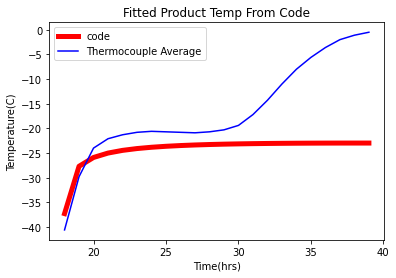

In [75]:
print("Fitted Temperature from OLS:\n",T_product)
print(cycle_time)
plt.plot(cycle_time,T_product,color="red",linewidth=5,label="code")
plt.plot(cycle_time,(df1[[' SPLYO.TC_AVG.F_CV']]).values[18:18+len(T_product)],color="blue",label="Thermocouple Average")
plt.xlabel("Time(hrs)")
plt.ylabel("Temperature(C)")
plt.title("Fitted Product Temp From Code")
plt.legend()

##  Iterative Code To Create Design Space

In [26]:
#Set Sampling Rate for Chamber Pressure and Shelf Temperatures(inputs to our model)
sr_t=10 #set sampling rate for temperature
sr_p=10 #set sampling rate for pressure
T_max=10
T_min=-30
P_max=250
P_min=50
temp=np.arange(T_min,T_max,sr_t) #Sample temperature 
press=np.arange(P_min,P_max,sr_p) #Sample pressure 

#Note: 
Using 2NN vial for the edge case. Took average for resistance parameters from F2 HH and F2 LL cycles. 

In [27]:
#Set Cake Resistance Parameters
    #I used the average between the cake res parameters for F2 LL and the F2 HH
cake_res_param1=np.array(([2.37967969e-04,1.50500000e+05,3.92977818e+00],[2.11020015e+02,1.50001112e+05,4.23697031e+00],[2.30943948e-03,1.20100000e+05,4.58371880e+00],[1.42191708e-03,1.20100000e+05,3.65804215e+00]))
cake_res_param2=np.array(([-8.85164801e-02,9.04999955e+04,6.50812284e+00],[2.18050145e+02,1.50001103e+05,1.56730158e+01],[1.79561470e-01,1.20100004e+05,1.07020467e+01],[-4.42872347e+02 ,1.20078699e+05 ,2.31393004e+01]))
cake_res_param=np.mean(np.array([ cake_res_param1, cake_res_param2 ]), axis=0 )

#Create Matrices to Store Predicted Drying Time and Product Temp at Each Pressure/Temp combo
dt=np.zeros((len(temp),len(press)))
tp=np.zeros((len(temp),len(press)))

#Start Iterations
for i in range(len(temp)):
    for j in range(len(press)):
        print("Current Pressure/Temp Combo:",temp[i],"C",press[j],"mTorr")
        
        #Set initial value for percent removed water
        prw_v=0
        #Set counter variable
        count=10
        
        while prw_v<100 and count<60: # keep iterating until prw reaches closest value to 100
            print("Current Iteration:", count-9)
            #Set Initial Arrays that will keep changing in length
            cycle_time=np.arange(18,count+18,1)
            Kv_values=np.repeat(0.00020961432864185497,count) #From Kv Fitting model, doesn't change based on vial configuration
            shelf_temp=np.repeat(temp[i],count) #In degrees Celsius
            cham_pres=np.repeat(press[j]/1000,count) #In Torr

            #OLS Function
            def ols_fit():
                #Define Parameter Set(Initial)
                #T_p_0=((df2[['TC AVG']]).values)[16:count+16] #Used thermocouple average as a starting point for the product temperature fitting
#                 T_p_0=(df1[[' SPLYO.TC_AVG.F_CV']]).values[18:count+18]
#                 T_p_0=(T_p_0.reshape(-1))
                T_p_0=np.repeat(-45,count)
                #Define Residuals Function
                def residuals(T_p): #T_p is the parameter we are fitting
                    #Need to calculate initial condition for cake resistance and Tice based on initial T_p_0 guess
                    #Go through all steps here
                    #Define function to calculate cake resistance and Tice
                    def intermed(T_p):
                        hf=(shelf_temp-T_p)*Kv_values
                        sh=np.zeros(hf.size)
                        for i in range(len(hf)):
                            if i==0:
                                sh[i]=0
                            else:
                                sh[i]=sh[i-1]+(hf[i]+hf[i-1])*(cycle_time[i]-cycle_time[i-1])*3600/2*Dout*Dout*np.pi/4
                        msi=sh/676
                        pdl=msi/(water_cont*ice_den*Din*Din*np.pi/4)
                        cake_res=(cake_res_param[3,0]+((cake_res_param[3,1]*pdl)/(1+cake_res_param[3,2]*pdl)))/1000 #Use 2NN case for edge
                        Tice_surf=T_p-hf*(dry_cake-pdl)/lam
                        return cake_res, Tice_surf
                    outputs=intermed(T_p) #variable to store cake res and Tice_surf
                    p_pred=np.exp(24.01849-6144.96/(outputs[1].astype("float64")+273.0)) #Have to set initial condition for Tice_surf
                    #p_pred=np.exp(24.01849-6144.96/(outputs[0]+273.0)) #Have to set initial condition for Tice_surf
                    p_real=cham_pres+outputs[0]*3600*((Dout*Dout)/(Din*Din))*Kv_values*(shelf_temp-T_p)/676 #Have to set initial condition for cake_res
                    p_real=np.array(p_real, dtype=float)
                    res=p_pred-p_real
                    return res
                #Least Squares Fitting
                lsq=least_squares(residuals,T_p_0, loss='soft_l1', f_scale=0.1)

                #Fitted Product Temperature
                T_p_fit=lsq.x

                return T_p_fit #final outcome T_p 
            ####   At this point you have fitted product temperature ####
            T_product=ols_fit()

            #Function to calculate all intermediate values used to fit the T_product
            def param(T_p):
                hf=(shelf_temp-T_p)*Kv_values
                sh=np.zeros(hf.size)
                for i in range(len(hf)):
                    if i==0:
                        sh[i]=0
                    else:
                        sh[i]=sh[i-1]+(hf[i]+hf[i-1])*(cycle_time[i]-cycle_time[i-1])*3600/2*Dout*Dout*np.pi/4
                msi=sh/676
                pdl=msi/(water_cont*ice_den*Din*Din*np.pi/4)
                cake_res=cake_res_param[3,0]+((cake_res_param[3,1]*pdl)/(1+cake_res_param[3,2]*pdl)) #2NN Case for edge model
                Tice_surf=T_p-hf*(dry_cake-pdl)/lam
                return cake_res, Tice_surf, hf, msi, sh, pdl

            #Find all intermediate values

            #Heat Flux
            hf_model=param(ols_fit())[2]
            #Sublimation Heat
            sh_model=param(ols_fit())[4]
            #Mass of Sublimed Ice 
            msi_model=param(ols_fit())[3]
            #Product Dried Layer
            pdl_model=param(ols_fit())[5]
            #Cake Resistance
            cake_res_model=param(ols_fit())[0]
            #Tice_surf
            Tice_model=param(ols_fit())[1]

            #Find the sublimation rate
            def sub_rate(HF):
                sr=np.zeros(HF.size)
                for i in range(len(HF)):
                    if i==0:
                        sr[i]=0
                    else:
                        sr[i]=vial_numbers*HF[i]*np.pi*math.pow(Dout,2)/(4*676)
                return sr
            sr=sub_rate(param(ols_fit())[2]) #g/s
            sr_kg=sr*3600/1000

            #Find the percent removed water
            def perc_wat():
                prw = ((((param(ols_fit()))[3]/water_cont)/fill_volume)/den)*100
                return prw 
            prw=perc_wat()

            #Increment the length of necessary variables by one
            count=count+1

            #Set prw_v as the new value
            prw_v=prw[prw.shape[0]-1] #Pick the last element of the prw array

        #Predict Drying Time Using the final output of the for loop for the prw
        drying_time=cycle_time[cycle_time.shape[0]-1]
        print("Drying Time(Hrs):", drying_time)
        #Predict Product Temperature Based on Maximum Temperature in the Array
        product_temp=np.max(T_product)
        print("Product Temperature(C):",product_temp)
        #Store Model Predictions for Drying Time and Product Temperature 
        dt[i,j]=drying_time
        tp[i,j]=product_temp


Current Pressure/Temp Combo: -30 C 50 mTorr
Current Iteration: 1
Current Iteration: 2
Current Iteration: 3
Current Iteration: 4
Current Iteration: 5
Current Iteration: 6
Current Iteration: 7
Current Iteration: 8
Current Iteration: 9
Current Iteration: 10
Current Iteration: 11
Current Iteration: 12
Current Iteration: 13
Current Iteration: 14
Current Iteration: 15
Current Iteration: 16
Current Iteration: 17
Current Iteration: 18
Current Iteration: 19
Current Iteration: 20
Current Iteration: 21
Current Iteration: 22
Current Iteration: 23
Current Iteration: 24
Current Iteration: 25
Current Iteration: 26
Current Iteration: 27
Current Iteration: 28
Current Iteration: 29
Current Iteration: 30
Current Iteration: 31
Current Iteration: 32
Current Iteration: 33
Current Iteration: 34
Current Iteration: 35
Current Iteration: 36
Current Iteration: 37
Current Iteration: 38
Current Iteration: 39
Current Iteration: 40
Current Iteration: 41
Current Iteration: 42
Current Iteration: 43
Current Iteration: 

In [28]:
#Create meshgrid
xx,yy=np.meshgrid(temp,press)

#Save Data as .csv
li = zip(xx.flatten(order='F'), yy.flatten(order='F'), dt.flatten(), tp.flatten())
df_out=pd.DataFrame(data=li,columns=["Shelf Temperature(C)","Chamber Pressure(mTorr)","Drying Time(Hrs)","Product Temperature(C)"])
df_out.to_csv(r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\Outputs\Design Space\data_log(Core)_incr.csv')